In [74]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier

CycleGAN_dir = "/Users/rogeriojorge/local/CycleGAN"
csv_file = "filtered_stel_results.csv"
df = pd.read_csv(os.path.join(CycleGAN_dir,csv_file))

In [77]:
repeated_rows = df.duplicated().sum()
print(f"Number of repeated rows: {repeated_rows}")

# # Save the filtered DataFrame to a CSV file
# # Drop duplicate rows
# filtered_df = df.drop_duplicates()
# filtered_csv_file = os.path.join(CycleGAN_dir, "filtered_stel_results.csv")
# filtered_df.to_csv(filtered_csv_file, index=False)
# print(f"Filtered DataFrame saved to {filtered_csv_file}")

Number of repeated rows: 0


In [78]:
df.head()

,file,qa,qh,qp,qi,iota_axis,iota_edge,mean_iota,mean_shear,well,...,am_pressure_18,am_pressure_19,am_pressure_20,nfp,iota_this_rho,shat_this_rho,d_pressure_d_s_this_rho,aspect_ratio,rho,aspect_ratio_over_rho
0,heliotron_randomAspect_finiteBeta_maxm1_maxn1_...,2.650177,24.862685,12.004428,NaN,1.224131,1.983320,1.545995,0.770753,-0.318374,...,0.0,0.0,0.0,7.0,-1.444513,-0.399702,-7147.861485,7.808516,0.636591,12.266141
1,nfp5_randomAspect_finiteBeta_maxm4_maxn4_LMN8_...,4.011591,6.962053,1.660388,NaN,0.377369,0.505873,0.429607,0.128108,0.035202,...,0.0,0.0,0.0,5.0,-0.446907,-0.453896,-10999.631955,9.290473,0.816752,11.374897
2,heliotron_randomAspect_finiteBeta_maxm1_maxn1_...,6.012151,43.372655,17.737168,NaN,1.208923,2.058605,1.569051,0.841264,-0.327240,...,0.0,0.0,0.0,8.0,-1.248198,-0.064149,-39219.057028,7.975512,0.268799,29.670942
3,heliotron_randomAspect_finiteBeta_maxm1_maxn1_...,17.571703,99.067110,36.139546,NaN,1.691149,2.289329,1.929345,0.606358,-0.421006,...,0.0,0.0,0.0,8.0,-1.977925,-0.448356,-27499.940107,7.868281,0.788187,9.982757
4,QUASR_finiteBeta_000356,0.000308,0.064281,0.064377,NaN,-0.812129,-0.805790,-0.803302,0.011251,0.029822,...,0.0,0.0,0.0,2.0,0.801330,0.023906,-33608.505728,5.000009,0.692649,7.218674


The ID with the lowest value of qi is: 248 with a value of 0.0064809442495964


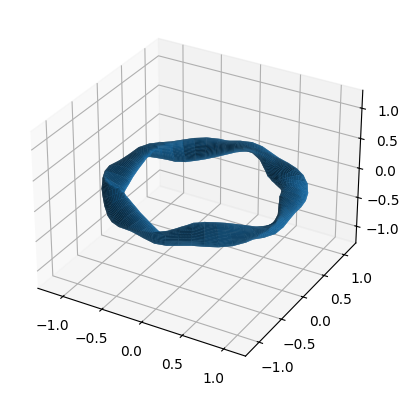

<Axes3D: >

In [79]:
quantity = 'qi'#'fixed_grad_Q_avgs_divided_by_FSA_grad_x'#qi, qa, qp, qh, aspect_ratio
lowest_qi_id = df[quantity].idxmin()
print(f"The ID with the lowest value of {quantity} is: {lowest_qi_id} with a value of {df[quantity].min()}")
row = lowest_qi_id
row_data = df.iloc[row]

quadpoints_phi = np.linspace(0, 1, 50, endpoint=True)
quadpoints_theta = np.linspace(0, 1, 40*int(row_data['nfp']), endpoint=True)
surf = SurfaceRZFourier(nfp=int(row_data['nfp']),mpol=8,ntor=8,quadpoints_phi=quadpoints_phi,quadpoints_theta=quadpoints_theta)
mode_names = [f"rbc_{m}_{n}" for m in range(0, 9) for n in range(-8, 9)] + \
             [f"zbs_{m}_{n}" for m in range(0, 9) for n in range(-8, 9)]
mode_names = [name for name in mode_names if name in df.columns]
surf_x = row_data[mode_names].values.astype(float)
surf.x = surf_x
surf.plot()

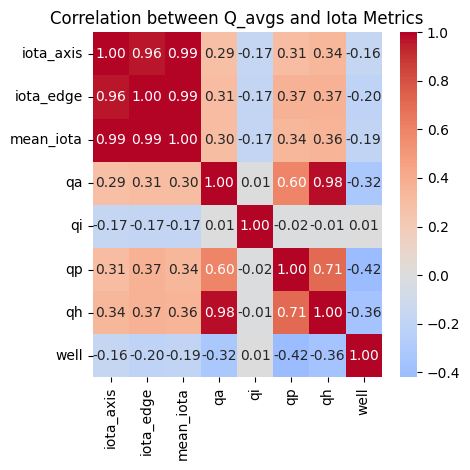

In [67]:

# Step 1: Identify relevant columns
cols = ["iota_axis", "iota_edge", "mean_iota", "qa", "qi", "qp", "qh", "well"]

# Step 2: Subset the DataFrame
sub_df = df[cols].copy()

# Step 3: Drop any rows with NaNs (optional but recommended)
sub_df = sub_df.dropna()

# Step 4: Compute the correlation matrix
corr = sub_df.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(len(corr.columns)*0.6, len(corr.columns)*0.6))
sns.heatmap(corr.loc[cols, cols], annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Q_avgs and Iota Metrics")
plt.tight_layout()
plt.show()